<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Enoncé" data-toc-modified-id="Enoncé-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Enoncé</a></span></li><li><span><a href="#Import-et-feature-engineering" data-toc-modified-id="Import-et-feature-engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import et feature engineering</a></span><ul class="toc-item"><li><span><a href="#Outils" data-toc-modified-id="Outils-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Outils</a></span></li><li><span><a href="#Application_train-et-Application-test" data-toc-modified-id="Application_train-et-Application-test-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Application_train et Application test</a></span></li><li><span><a href="#Drops" data-toc-modified-id="Drops-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Drops</a></span></li><li><span><a href="#Bureau.csv-et-bureau_balance.csv" data-toc-modified-id="Bureau.csv-et-bureau_balance.csv-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Bureau.csv et bureau_balance.csv</a></span></li><li><span><a href="#previous_applications.csv,-POS_CASH_balance.csv,-installments_payments.csv,-credit_card_balance.csv" data-toc-modified-id="previous_applications.csv,-POS_CASH_balance.csv,-installments_payments.csv,-credit_card_balance.csv-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>previous_applications.csv, POS_CASH_balance.csv, installments_payments.csv, credit_card_balance.csv</a></span></li><li><span><a href="#Merge-de-tous-les-fichiers-et-savegarde-du-fichier-final" data-toc-modified-id="Merge-de-tous-les-fichiers-et-savegarde-du-fichier-final-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Merge de tous les fichiers et savegarde du fichier final</a></span></li></ul></li><li><span><a href="#Notebooks" data-toc-modified-id="Notebooks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Notebooks</a></span></li><li><span><a href="#Bibliography" data-toc-modified-id="Bibliography-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bibliography</a></span></li></ul></div>

# Enoncé

# Import et feature engineering

Le notebook est basé sur https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/comments
et https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction#Conclusions

In [45]:
# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/comments
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib
import mlflow.sklearn

## Outils

In [85]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def most_positive_corr(df,columns):
   # for col in columns:
   #     correlations = df.corr()[col].sort_values(ascending=False)
   #     print('Most Positive Correlations with', col , ':\n', correlations.head(4))
    print()
    
def heatmapper(df,palette):
    corr = df.corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Affichage
    f, ax = plt.subplots(figsize=(17, 17))
    cmap = sns.color_palette(palette, as_cmap=True)

    # heatmap
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

def cat_value_counts(df):
    df_cat = [col for col in df.columns if df[col].dtype == 'object']    
    for col in df_cat:
        print("Feature\n", df[col].value_counts())
    

Le dataset est décrit dans https://www.kaggle.com/competitions/home-credit-default-risk/data

## Application_train et Application test

Les 2 fichiers son mergés pour les traiter ensembles. Puis le outliers sont supprimés ou remplacés par nan (voir https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction#Conclusions). Après binarisation et one hot encoding, on calcule quelques nouveaux features.

## Drops

In [86]:
# Drops utilisées dasn le kernel choisi, 7e dans le concours Kaggle

def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI',
        'FLOORSMAX_AVG','ENTRANCES_MEDI','AMT_REQ_CREDIT_BUREAU_HOUR', 'DAYS_LAST_PHONE_CHANGE',
        'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT','YEARS_BEGINEXPLUATATION_MEDI',
        'NAME_TYPE_SUITE','HOUSETYPE_MODE' ,'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE','WALLSMATERIAL_MODE',
        'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START','ORGANIZATION_TYPE'

    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [91]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)

    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))

    # Plot des solvable (0) ou non solvables (1)
    target_values = df['TARGET'].value_counts()/len(df)*100
    plt.pie(target_values,
            colors=['limegreen', 'red'],
            autopct='%1.1f%%',
            labels=["0 - Solvable", "1 - Non Solvable"],
            startangle=90)
    plt.show()
        
    #Les 2 fichiers sont mergés pour les traiter au meme temps
    df = df.append(test_df).reset_index()

    # Outliers: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    print    
    
    # XNA est simplement un not available
    df.replace('XNA', np.nan)
    
    # Pour ce projet mon turor conseille de garder environ 50 feature
    # ce qui se traduit en une legere baisse du roc

    
    # Drop features based on permutation feature importance (tire du kernel choisi)
    df =drop_application_columns(df)


    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR','NAME_CONTRACT_TYPE']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # engineering (un peu fantasiste) pour NAME_EDUCATION_TYPE
    # avec dictionnaire des annees de scolarisation
    years_in_school= {'Academic degree': 20, 'Higher education': 17, 'Incomplete higher': 15,
    'Lower secondary': 8,'Secondary / secondary special': 12}   
    df['NAME_EDUCATION_TYPE']=df['NAME_EDUCATION_TYPE'].map(years_in_school).apply(pd.to_numeric)
        
    # engineering de 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE' :
    # je remplace avec le salaire median par job    
    for x in ['NAME_INCOME_TYPE', 'OCCUPATION_TYPE']:
        dct=df.groupby(x).agg({'AMT_INCOME_TOTAL': ['median']}).apply(list).to_dict()    
        print(list(dct.values())[0])    
        df[x]=df[x].map(list(dct.values())[0]).apply(pd.to_numeric)
     
            
    # Je supprime les features les plus redondantes:
    # similaires et avec une correlation forte
    
    n_columns = [col for col in df.columns[3:] if df[col].dtype != 'object']
    
    
    # Find correlations with ...
    most_positive_corr(df,n_columns)
 

    # Drop de quelques colonnes redondantes
    df.drop(['CNT_CHILDREN', # CNT_FAM_MEMBERS    0.878912
            'REGION_RATING_CLIENT_W_CITY', # REGION_RATING_CLIENT  0.949647
            'DEF_60_CNT_SOCIAL_CIRCLE', #  DEF_30_CNT_SOCIAL_CIRCLE  0.865257
            'APARTMENTS_MEDI', # APARTMENTS_AVG 0.995341
            'APARTMENTS_MODE', # APARTMENTS_AVG 0.973969
            'LIVINGAREA_AVG', # APARTMENTS_AVG 0.913101
            'TOTALAREA_MODE', #APARTMENTS_AVG  0.891406
            'ENTRANCES_AVG', #APARTMENTS_AVG
            'NAME_FAMILY_STATUS',#family members
            'NAME_HOUSING_TYPE' # mon choix arbitraire
            ], axis=1, inplace= True)
        

    # Outliers : NaN values for DAYS_EMPLOYED: 365.243 -> nan. Plus de details dans https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction#Conclusions
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    print('Shape avant ohe', df.shape)
        
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    print('Shape après ohe', df.shape)
    print(cat_cols)
        
    
    # Data Engineering 
    df['INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['CREDIT_PRICE_DIFF'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    # New features based on External sources
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
   
    # Drop des colonnes engineered
    df.drop(['AMT_INCOME_TOTAL','AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS','AMT_ANNUITY',
            'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],
            axis=1, inplace= True)

    print(df.columns)
    
    
    heatmapper(df,"rocket_r")
    
            
    # Find correlations with the target and sort
    correlations = df.corr()['TARGET'].sort_values(ascending=False)

    # Display correlations
    print('Most Positive Correlations:\n', correlations.head(20))
    print('\nMost Negative Correlations:\n', correlations.tail(20))

    
    del test_df
    gc.collect()
    return df


In [92]:
# preview du dataframe de base
#application_train_test()

## Bureau.csv et bureau_balance.csv

Les 2 fichiers sont importés, one hot encoded, agregés e mergés https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/comments . J'ai choisi la version "simple" du code avec min, max, mean, parce que je n'ai aucune competence métier. Il faudrait échanger avec un specialiste du domaine.



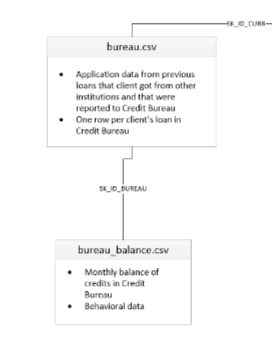

In [93]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = False):
    
    # read
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)

    # XNA = nan
    bureau.replace('XNA', np.nan, inplace= True)
    bb.replace('XNA', np.nan, inplace= True)

    print(bureau.info(),'\n', bureau.head(3))
    print(bb.info(),'\n', bb.head(3))
    
    # bureau features categorielles
    cat_value_counts(bureau)

    # drop feature categorielle avec une valeur dominante
    bureau.drop(['CREDIT_CURRENCY'], axis=1, inplace= True)

    # map des categories consumer credit / loan
    loan=['Car loan', 'Mortgage', 'Microloan', 'Another type of loan', 'Unknown type of loan',
        'Loan for business development', 'Loan for working capital replenishment','Cash loan (non-earmarked)', 
        'Real estate loan', 'Loan for the purchase of equipment', 'Loan for purchase of shares (margin lending)',
        'Mobile operator loan']
    credit=['Interbank credit', 'Consumer credit', 'Credit card']
    bureau['CREDIT_TYPE'].replace(loan, "Loan", inplace=True)
    bureau['CREDIT_TYPE'].replace(credit, "Customer_credit", inplace=True)

    # engineering de STATUS
    # STATUS,"Status of Credit Bureau loan during the month 
    # C means closed, 
    # X means status unknown, --> nan
    # 0 means no DPD days past due,
    # 1 means maximal did during month between 1-30, 
    # 2 means DPD 31-60,
    # … 5 means DPD 120+ or sold or written off ] )",
    print(bb['STATUS'].value_counts())
    dpd={"C":0, "0":0, "1":30, "2":60, "3":90, "4":120, "5":240}
    bb['STATUS_CLOSED']=(bb['STATUS']=='C').astype(int)
    bb['STATUS_DPD']=bb['STATUS'].map(dpd)
    bb.drop(['STATUS'], axis=1, inplace= True)
    print(bb.info())

    #OHE
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    print('Bureau apres ohe', bureau.info())
    print('Balance apres engineering', bb.info())
    

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['size'],
                      'STATUS_CLOSED': ['mean'], # sum correle a months balance
                      'STATUS_DPD': ['sum'],}
    
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    
    print("Aggregations bb\n",bb_agg)
    
    #merge
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    print('Merged Bureau\n', bureau.shape)
    # engineering
    
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    # Credit to debt difference
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']

    # Drop
    bureau.drop(['DAYS_CREDIT','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT',
                 'AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT','CREDIT_TYPE_Customer_credit','AMT_CREDIT_MAX_OVERDUE'], axis=1, inplace= True)

    heatmapper(bureau,"mako_r")

    
    print('Bureau apres drop\n',  bureau.describe())
    
    # Bureau and bureau_balance numeric features
    
    print (bureau.columns)   
    
    num_aggregations = {
        'CREDIT_DURATION': ['mean'],
        'DEBT_CREDIT_DIFF': ['sum'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean'],
        'AMT_ANNUITY': ['mean'],
        'CNT_CREDIT_PROLONG': ['mean'],
        'MONTHS_BALANCE_SIZE': ['mean'],
        'STATUS_CLOSED_MEAN': ['mean'],
        'STATUS_DPD_SUM': ['mean']

    }
    # Bureau and bureau_balance categorical features
        
    cat_aggregations = {}
    for cat in ['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_TYPE_Loan']: cat_aggregations[cat] = ['sum']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['Buro_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    print(bureau_agg.head())
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] > 0]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['Buro_ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] > 0]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['Buro_CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()

    
    
    print(bureau_agg.columns)
    # heatmap

    heatmapper(bureau_agg,"mako_r")

      
    bureau_agg.drop(['Buro_CREDIT_DURATION_MEAN', 'Buro_DEBT_CREDIT_DIFF_SUM',
       'Buro_DAYS_CREDIT_UPDATE_MEAN', 'Buro_CREDIT_DAY_OVERDUE_MEAN',
       'Buro_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'Buro_AMT_CREDIT_SUM_LIMIT_MEAN', 'Buro_AMT_ANNUITY_MEAN',
       'Buro_CNT_CREDIT_PROLONG_MEAN', 'Buro_MONTHS_BALANCE_SIZE_MEAN',
       'Buro_STATUS_CLOSED_MEAN_MEAN', 'Buro_STATUS_DPD_SUM_MEAN',
       'Buro_CREDIT_ACTIVE_Active_SUM','Buro_CREDIT_ACTIVE_Closed_SUM'], axis=1, inplace=True)

    heatmapper(bureau_agg,"mako_r")
                    
                 
    print (bureau_agg.isnull().sum() * 100 / len(bureau_agg))
    return bureau_agg


In [94]:
# bureau_and_balance()

## previous_applications.csv, POS_CASH_balance.csv, installments_payments.csv, credit_card_balance.csv


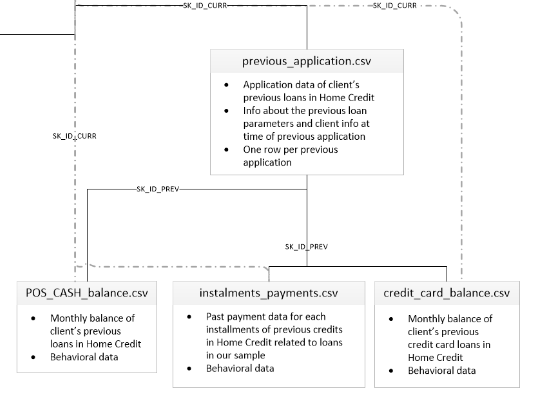

In [95]:
#previous_applications()

In [114]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = False):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    
    prev.info()

    # XNA = nan
    prev.replace('XNA', np.nan, inplace= True)

    cat_value_counts(prev)
    
    # drop des memes features que j'ai supprimes dans application.csv
        # grande majorite d'un feature ou inconnu
        # trop de detail ex. PRODUCT_COMBINATION,Detailed product combination of the previous application,trop de detail
  
    prev.drop(['WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','NAME_TYPE_SUITE','NFLAG_INSURED_ON_APPROVAL',
            'NAME_PAYMENT_TYPE','PRODUCT_COMBINATION', 'NAME_PORTFOLIO','NFLAG_LAST_APPL_IN_DAY',
            'NAME_SELLER_INDUSTRY', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON','RATE_DOWN_PAYMENT',
                'CHANNEL_TYPE', 'NAME_PRODUCT_TYPE','NAME_GOODS_CATEGORY', 'FLAG_LAST_APPL_PER_CONTRACT',
              'RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED','SELLERPLACE_AREA'], axis= 1, inplace = True)

    
        
 #  206,previous_application.csv,NAME_YIELD_GROUP,Grouped interest rate into small medium and high of the previous application,grouped
    level={'XNA' : np.NaN, 'high':1000, 'middle':100, 'low_normal': 1, 'low_action': 10}
    prev['NAME_YIELD_GROUP']=prev['NAME_YIELD_GROUP'].map(level).apply(pd.to_numeric)

    
    prev['NAME_CONTRACT_TYPE'].replace('XNA', np.nan, inplace= True)
    prev['NAME_CLIENT_TYPE'].replace('XNA', np.nan, inplace= True)

    
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)

    
    # Outliers (les memes) Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)


    # Data Engineering 
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']    
    prev['APPLICATION_PRICE_DIFF'] = prev['AMT_APPLICATION']  -  prev['AMT_GOODS_PRICE']
    prev['PAYMENT_RATE'] = prev['AMT_ANNUITY'] / prev['AMT_CREDIT']
   
    # Drop des colonnes engineered ou tres correlees
    prev.drop(['AMT_GOODS_PRICE','AMT_APPLICATION', 'DAYS_LAST_DUE_1ST_VERSION', 'AMT_ANNUITY',
             'DAYS_FIRST_DUE', 'DAYS_FIRST_DRAWING', 'DAYS_LAST_DUE', 'NAME_YIELD_GROUP', 'DAYS_TERMINATION'],
            axis=1, inplace= True)

    most_positive_corr(prev,prev.columns)

   
    prev.info()
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_CREDIT': ['mean'],
        'APPLICATION_CREDIT_DIFF': ['sum'],
        'AMT_DOWN_PAYMENT': ['mean'],
        'APPLICATION_PRICE_DIFF': ['mean'],
        'DAYS_DECISION': ['mean'],
        'CNT_PAYMENT': ['sum'],

    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['sum']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['Prev_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] > 0]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] > 0]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Canceled Applications - only numerical features
#    canceled = prev[prev['NAME_CONTRACT_STATUS_Canceled'] > 0]
#    canceled_agg = canceled.groupby('SK_ID_CURR').agg(num_aggregations)
#    canceled_agg.columns = pd.Index(['CANCELED_' + e[0] + "_" + e[1].upper() for e in canceled_agg.columns.tolist()])
#    prev_agg = prev_agg.join(canceled_agg, how='left', on='SK_ID_CURR')

    del refused, refused_agg, approved, approved_agg, prev#, canceled_agg, canceled
    gc.collect()

    print(prev_agg.columns)
    #tres correles
    prev_agg.drop(['Prev_NAME_CLIENT_TYPE_Repeater_SUM'], axis= 1, inplace = True)
    
    
    
    # heatmap    
    heatmapper(prev_agg,"cubehelix_r")
    
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = False):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    
    pos.info()
    # XNA = nan
    pos.replace('XNA', np.nan, inplace= True)
    # features categorielles
    cat_value_counts(pos)

    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['mean'],
        'SK_DPD': ['mean'],
        'SK_DPD_DEF': ['mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['Pos_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    # heatmap    
    heatmapper(pos_agg,"BuPu")
        
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category)

    ins.info()
    # XNA = nan
    ins.replace('XNA', np.nan, inplace= True)
    # features categorielles
    cat_value_counts(ins)
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    ins.drop(['DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT'], axis=1, inplace= True)
    
    
    
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['mean'],
        'DBD': ['mean'],
        #'PAYMENT_DIFF': ['sum'],
        'AMT_INSTALMENT': ['mean'],
        'AMT_PAYMENT': ['sum'],
        #'DAYS_ENTRY_PAYMENT': ['mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['Inst_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    
    heatmapper(ins_agg,"BuGn")

    
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = False):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    
    cc.info()
    
    # XNA = nan
    cc.replace('XNA', np.nan, inplace= True)

    # features categorielles
    cat_value_counts(cc)

    cc, cat_cols = one_hot_encoder(cc, nan_as_category)
        
    most_positive_corr(cc,cc.columns)   
                
    cc.drop(['AMT_RECEIVABLE_PRINCIPAL','AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'AMT_PAYMENT_CURRENT',
            'CNT_DRAWINGS_POS_CURRENT','AMT_INST_MIN_REGULARITY','NAME_CONTRACT_STATUS_Active'], axis=1, inplace= True)
    
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['mean'])
    cc_agg.columns = pd.Index(['Cc_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    del cc
    gc.collect()
    
    # heatmap    
    heatmapper(cc_agg,"pink_r")

    return cc_agg

In [115]:
#credit_card_balance()

In [116]:
#installments_payments()

In [117]:
#pos_cash()

## Merge de tous les fichiers et savegarde du fichier final

In [118]:
def main(debug = False, nan_as_category = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows, nan_as_category)
    print("Dataframe shape",df.shape)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows, nan_as_category)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
        print("Dataframe shape",df.shape)

    with timer("Process previous_applications"):
        prev = previous_applications(num_rows, nan_as_category)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
        print("Dataframe shape",df.shape)

    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows, nan_as_category)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
        print("Dataframe shape",df.shape)

    with timer("Process installments payments"):
        ins = installments_payments(num_rows, nan_as_category)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
        print("Dataframe shape",df.shape)

    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows, nan_as_category)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        print("Dataframe shape",df.shape)

        
    # normalization des noms des colonnes
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    print("Dataframe shape",df.shape)
 

    
    # drop des colonnes avec plus de 75% de nans
    df = df.loc[:, df.isnull().sum() < 0.75*df.shape[0]]
    
    print("Dataframe shape après drops",df.shape)
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Train Dataframe shape",train_df.shape)
    print("Test Dataframe shape",train_df.shape)
    
    # Find correlations with the target and sort
    with timer("Find correlation"):
        print('Calcul des Correlations...')
        correlations = df.corr()['TARGET'].sort_values(ascending=False)

    # Display correlations
        print('Most Positive Correlations:\n', correlations.head(20))
        print('\nMost Negative Correlations:\n', correlations.tail(20))

    # save Dataframe
    with timer("Save dataframe"):
        print('\nSaving...\n')
        savedataframe = "debugdataframe.csv" if debug else "shorterapidataframe.csv"
        print("Saving Dataframe",savedataframe)
        df.to_csv(savedataframe, index= False)
    return df

Train samples: 307511, test samples: 48744


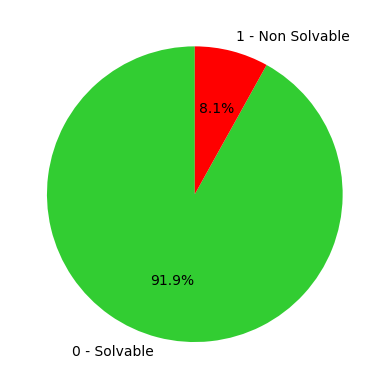

{'Businessman': 450000.0, 'Commercial associate': 180000.0, 'Maternity leave': 90000.0, 'Pensioner': 121500.0, 'State servant': 157500.0, 'Student': 157500.0, 'Unemployed': 90000.0, 'Working': 144000.0}
{'Accountants': 180000.0, 'Cleaning staff': 117000.0, 'Cooking staff': 135000.0, 'Core staff': 157500.0, 'Drivers': 180000.0, 'HR staff': 162000.0, 'High skill tech staff': 157500.0, 'IT staff': 180000.0, 'Laborers': 157500.0, 'Low-skill Laborers': 126000.0, 'Managers': 225000.0, 'Medicine staff': 135000.0, 'Private service staff': 157500.0, 'Realty agents': 180000.0, 'Sales staff': 135000.0, 'Secretaries': 135000.0, 'Security staff': 135000.0, 'Waiters/barmen staff': 135000.0}

Shape avant ohe (356251, 31)
Shape après ohe (356251, 31)
[]
Index(['index', 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'AMT_CREDIT', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION',

Aggregations bb
               MONTHS_BALANCE_SIZE  STATUS_CLOSED_MEAN  STATUS_DPD_SUM
SK_ID_BUREAU                                                         
5001709                        97            0.886598             0.0
5001710                        83            0.578313             0.0
5001711                         4            0.000000             0.0
5001712                        19            0.473684             0.0
5001713                        22            0.000000             0.0
...                           ...                 ...             ...
6842884                        48            0.416667             0.0
6842885                        24            0.000000          2880.0
6842886                        33            0.757576             0.0
6842887                        37            0.837838             0.0
6842888                        62            0.838710            30.0

[817395 rows x 3 columns]
Merged Bureau
 (1716428, 22)
Bureau apres drop

Index(['Buro_CREDIT_DURATION_MEAN', 'Buro_DEBT_CREDIT_DIFF_SUM',
       'Buro_DAYS_CREDIT_UPDATE_MEAN', 'Buro_CREDIT_DAY_OVERDUE_MEAN',
       'Buro_AMT_CREDIT_SUM_OVERDUE_MEAN', 'Buro_AMT_CREDIT_SUM_LIMIT_MEAN',
       'Buro_AMT_ANNUITY_MEAN', 'Buro_CNT_CREDIT_PROLONG_MEAN',
       'Buro_MONTHS_BALANCE_SIZE_MEAN', 'Buro_STATUS_CLOSED_MEAN_MEAN',
       'Buro_STATUS_DPD_SUM_MEAN', 'Buro_CREDIT_ACTIVE_Active_SUM',
       'Buro_CREDIT_ACTIVE_Bad debt_SUM', 'Buro_CREDIT_ACTIVE_Closed_SUM',
       'Buro_CREDIT_ACTIVE_Sold_SUM', 'Buro_CREDIT_TYPE_Loan_SUM',
       'Buro_ACTIVE_CREDIT_DURATION_MEAN', 'Buro_ACTIVE_DEBT_CREDIT_DIFF_SUM',
       'Buro_ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'Buro_ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
       'Buro_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'Buro_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN', 'Buro_ACTIVE_AMT_ANNUITY_MEAN',
       'Buro_ACTIVE_CNT_CREDIT_PROLONG_MEAN',
       'Buro_ACTIVE_MONTHS_BALANCE_SIZE_MEAN',
       'Buro_ACTIVE_STATUS_CLOSED_MEAN_MEAN',
 

Feature
 POS      691011
Cash     461563
Cards    144985
Cars        425
Name: NAME_PORTFOLIO, dtype: int64
Feature
 x-sell     456287
walk-in    150261
Name: NAME_PRODUCT_TYPE, dtype: int64
Feature
 Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: CHANNEL_TYPE, dtype: int64
Feature
 Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: NAME_SELLER_INDUSTRY, dtype: int64
Feature
 middle        385532
high          353331
low_normal    322095
low_action     92041
Name: NAME_YIELD_G

Save dataframe - done in 31s


,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,Cc_CNT_DRAWINGS_CURRENT_MEAN,Cc_CNT_INSTALMENT_MATURE_CUM_MEAN,Cc_SK_DPD_MEAN,Cc_SK_DPD_DEF_MEAN,Cc_NAME_CONTRACT_STATUS_Approved_MEAN,Cc_NAME_CONTRACT_STATUS_Completed_MEAN,Cc_NAME_CONTRACT_STATUS_Demand_MEAN,Cc_NAME_CONTRACT_STATUS_Refused_MEAN,Cc_NAME_CONTRACT_STATUS_Sentproposal_MEAN,Cc_NAME_CONTRACT_STATUS_Signed_MEAN
0,0,100002,1.0,0,0,0,406597.5,144000.0,12,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,0,1,0,1293502.5,157500.0,17,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,1,0,1,135000.0,144000.0,12,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,0,1,0,312682.5,144000.0,12,0.008019,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,100007,0.0,0,0,0,513000.0,144000.0,12,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,0,1,0,412560.0,144000.0,12,0.002042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,48740,456222,NaN,0,1,0,622413.0,180000.0,12,0.035792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,48741,456223,NaN,0,1,1,315000.0,180000.0,12,0.026392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,48742,456224,NaN,0,0,0,450000.0,180000.0,17,0.018850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


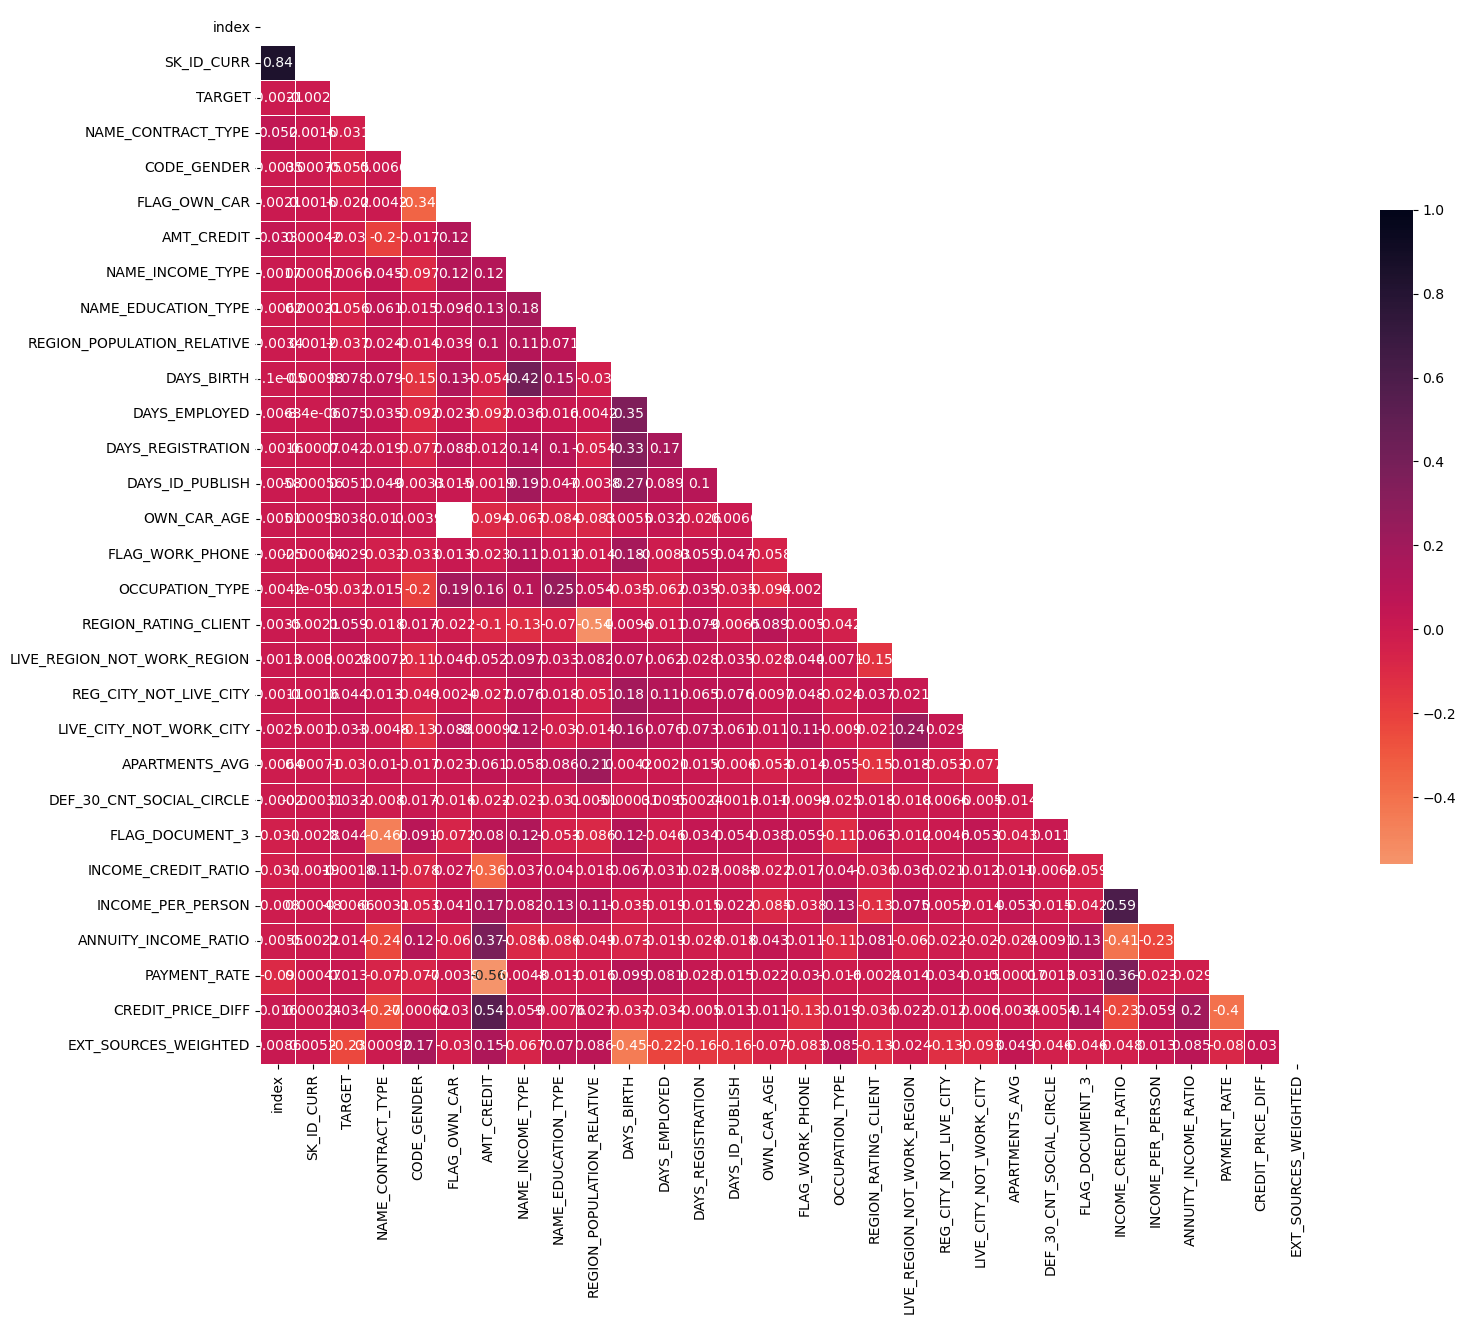

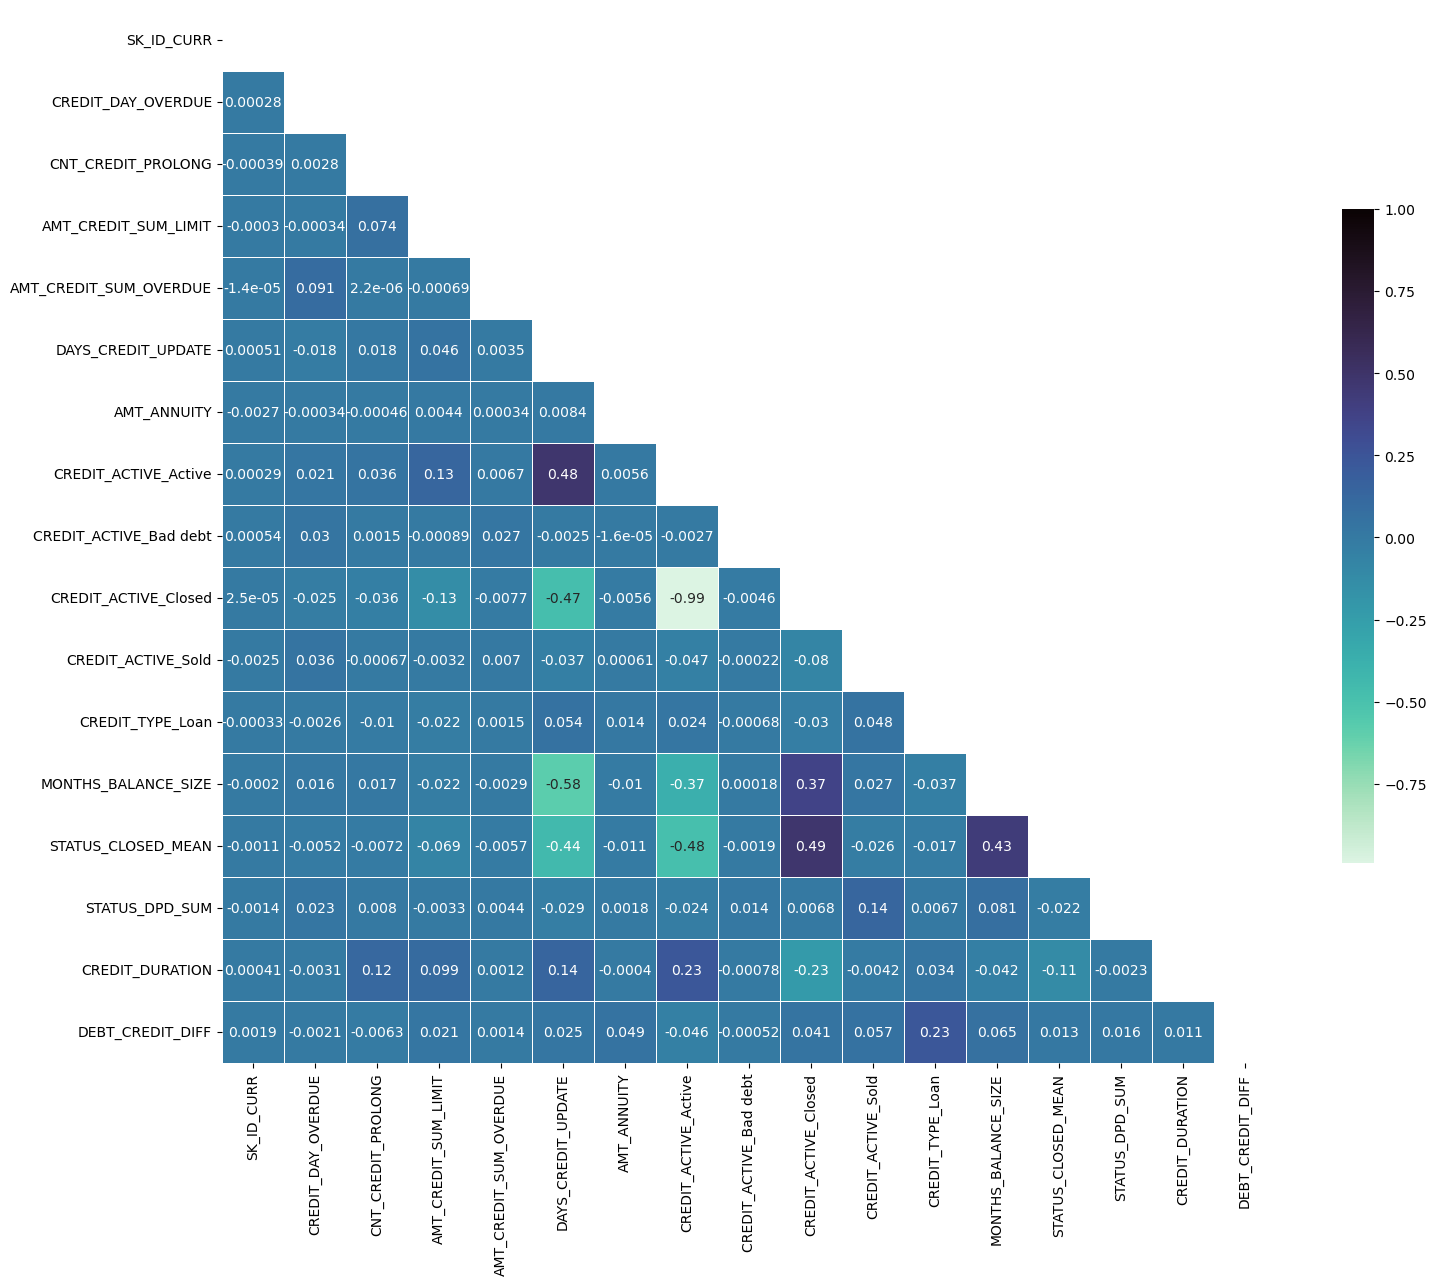

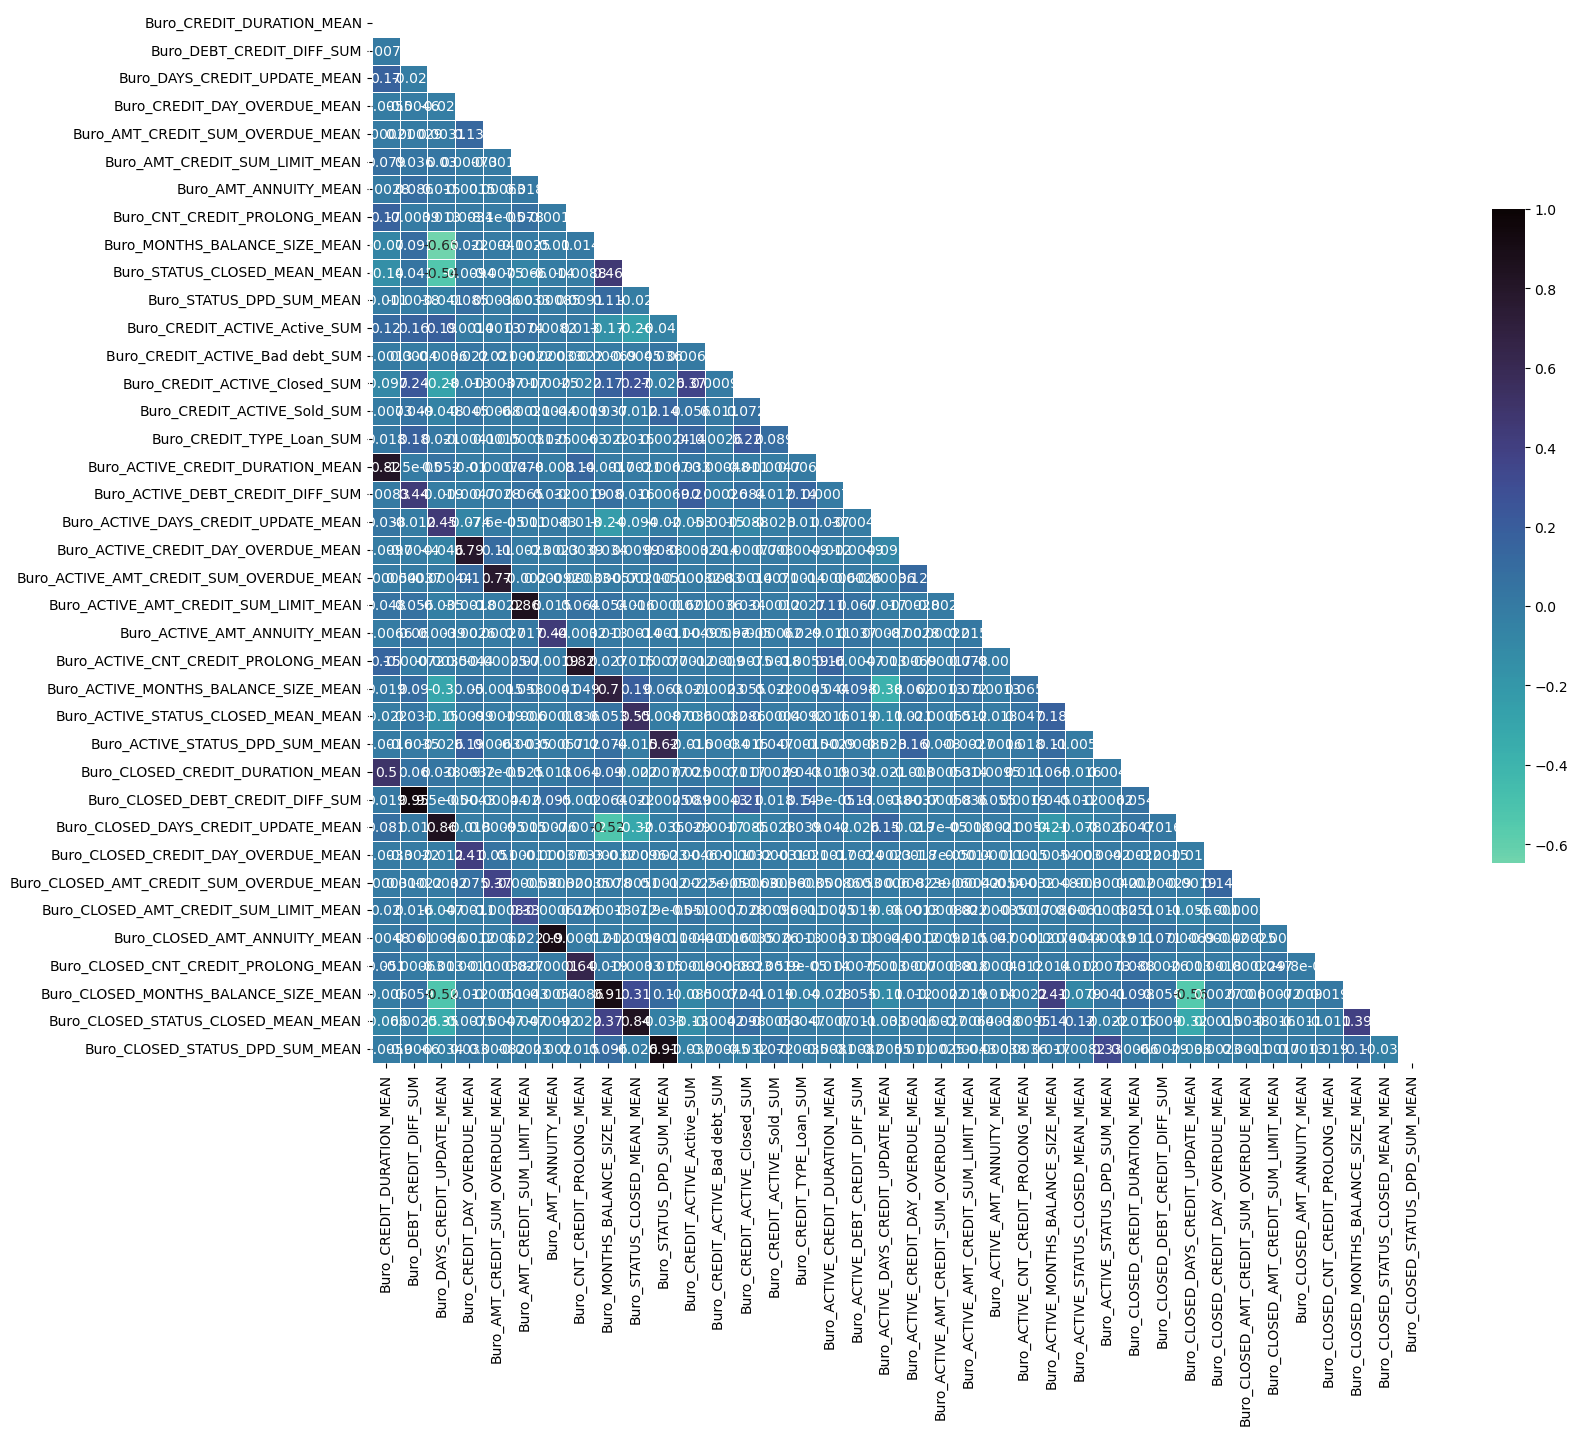

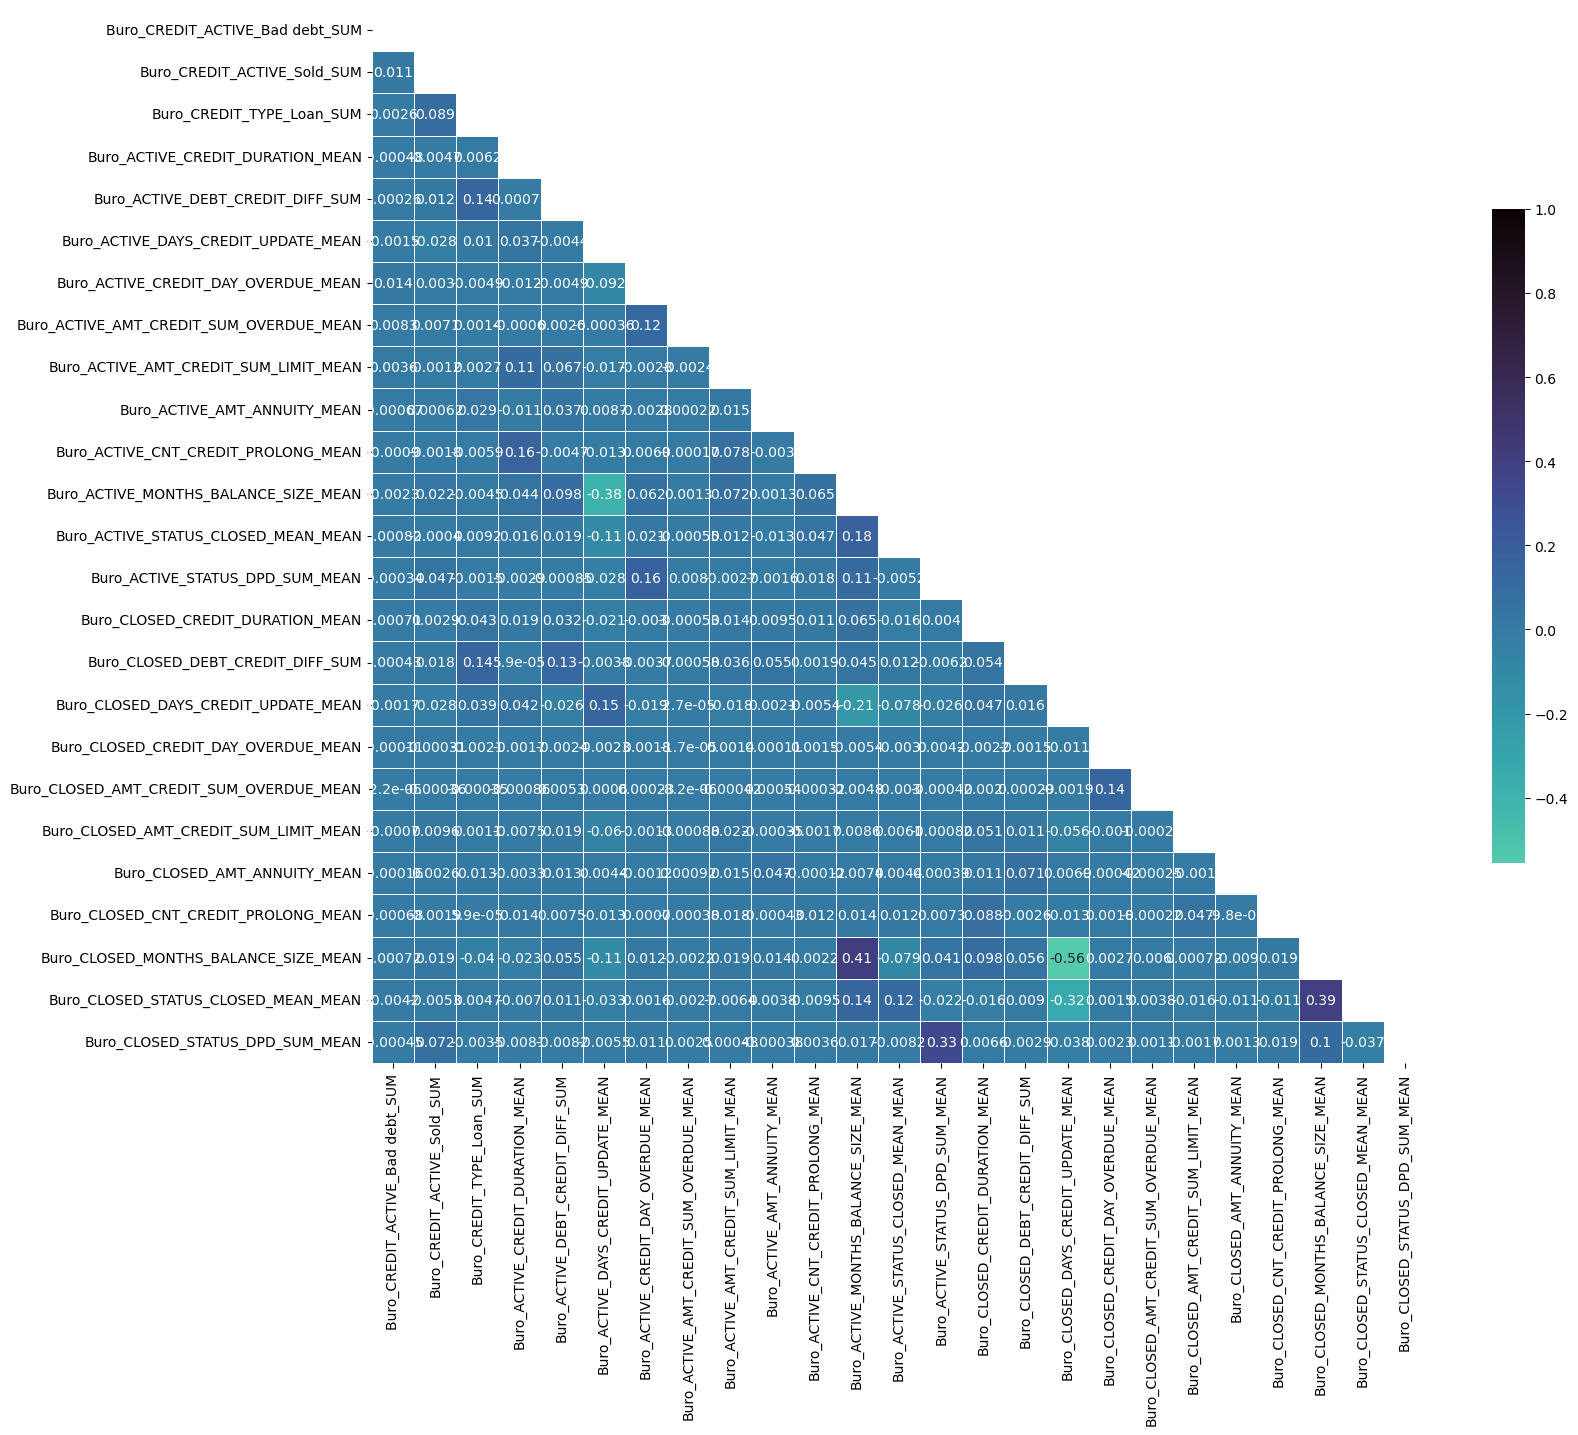

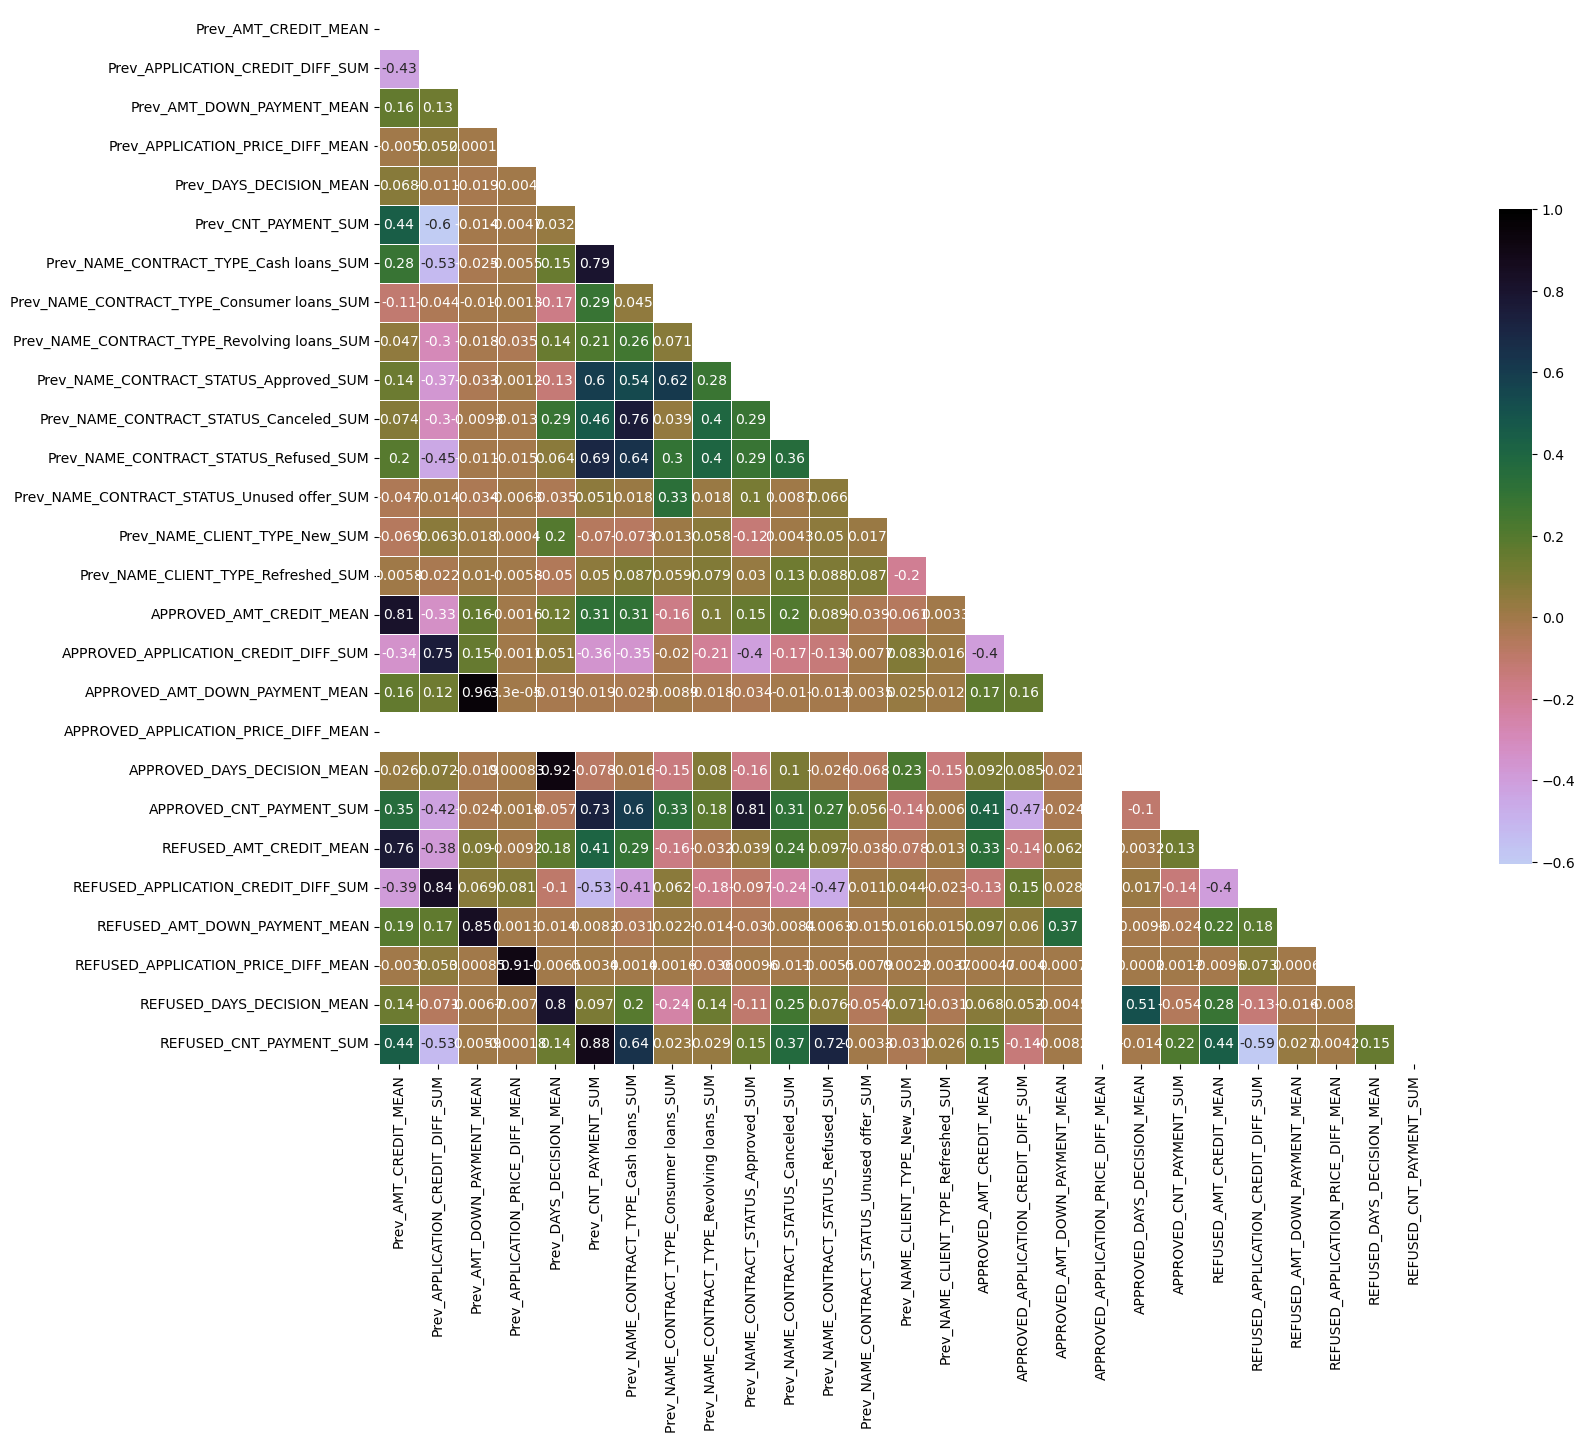

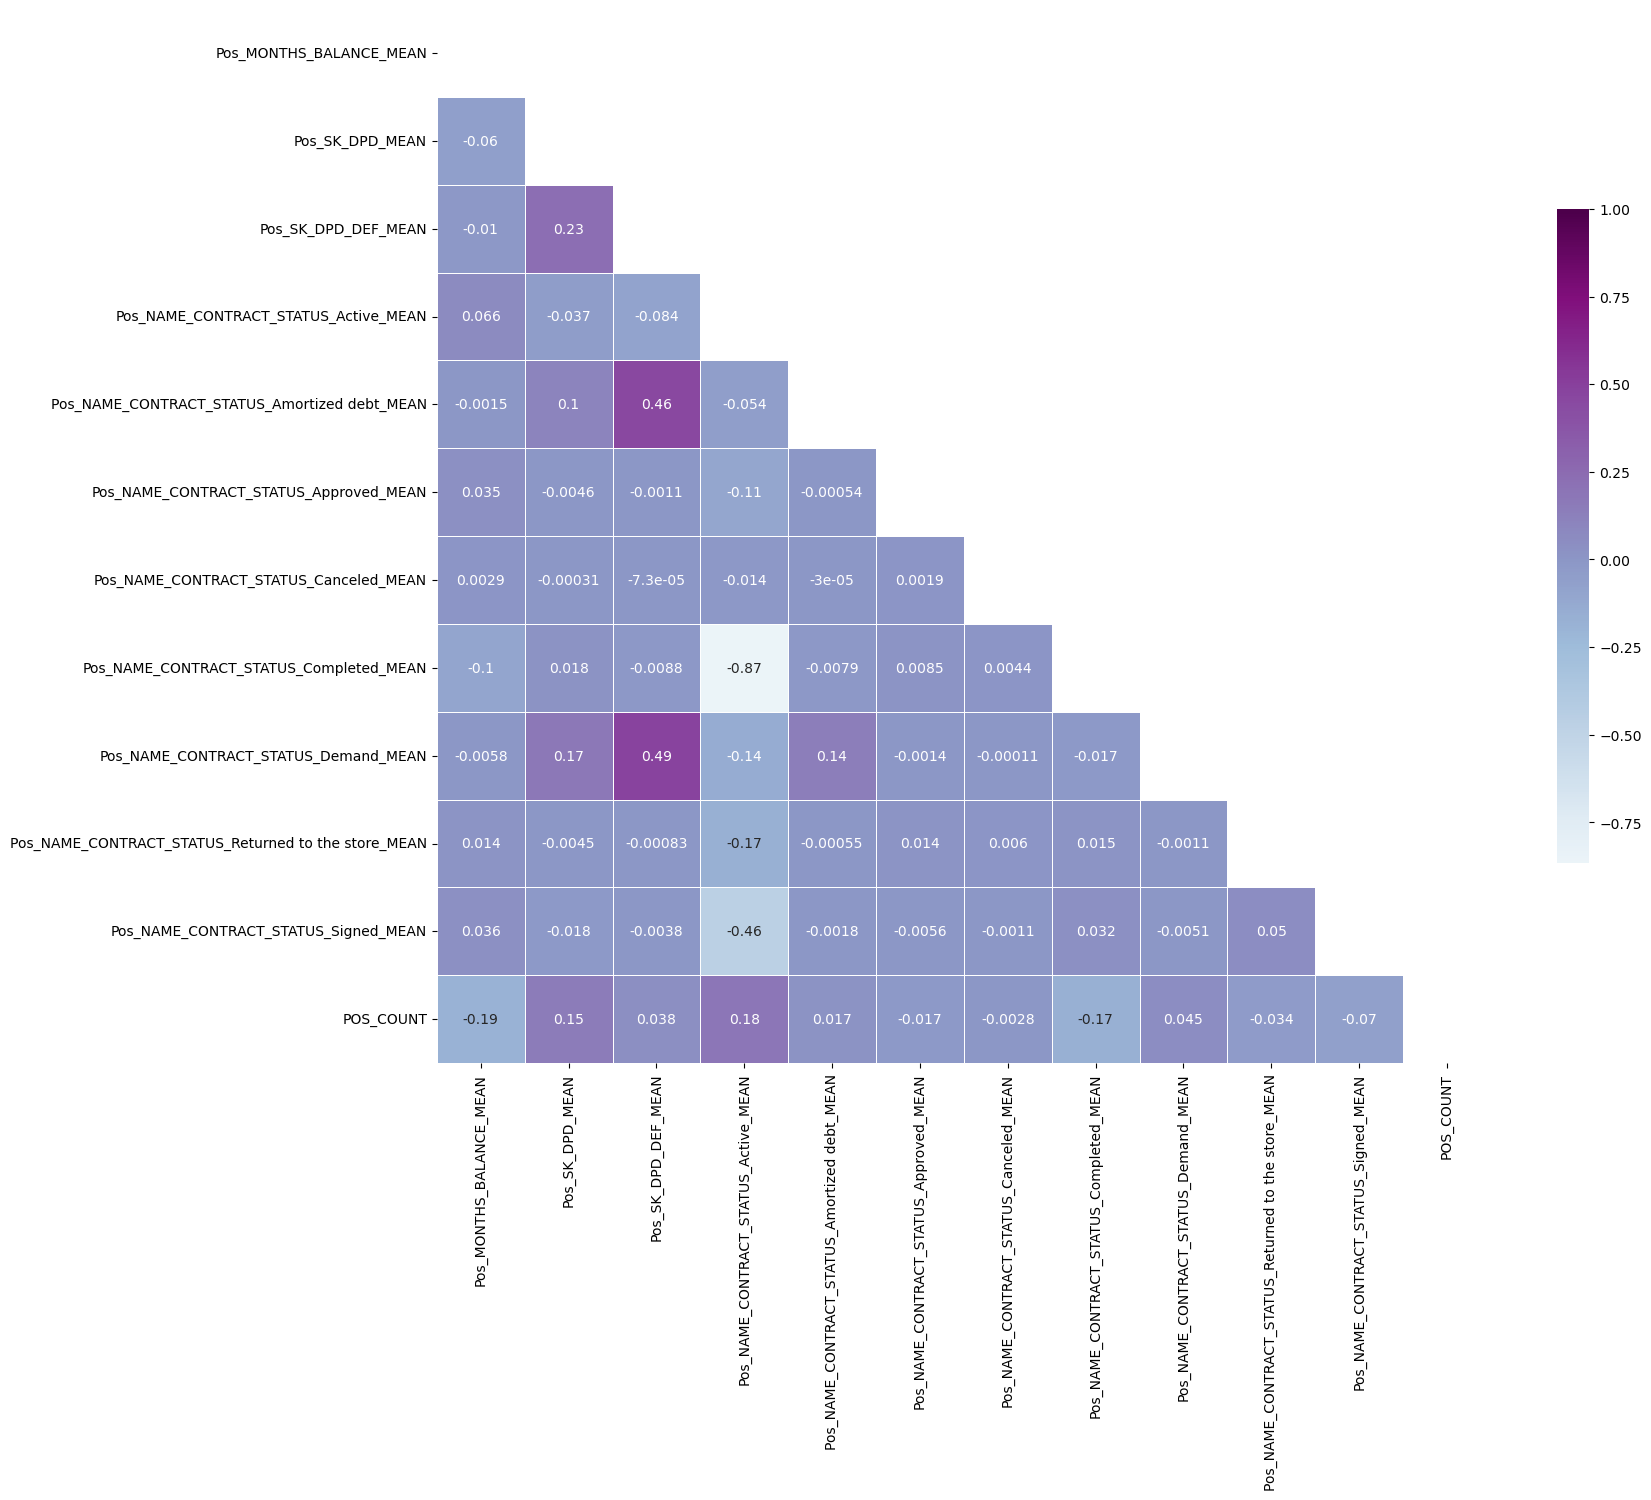

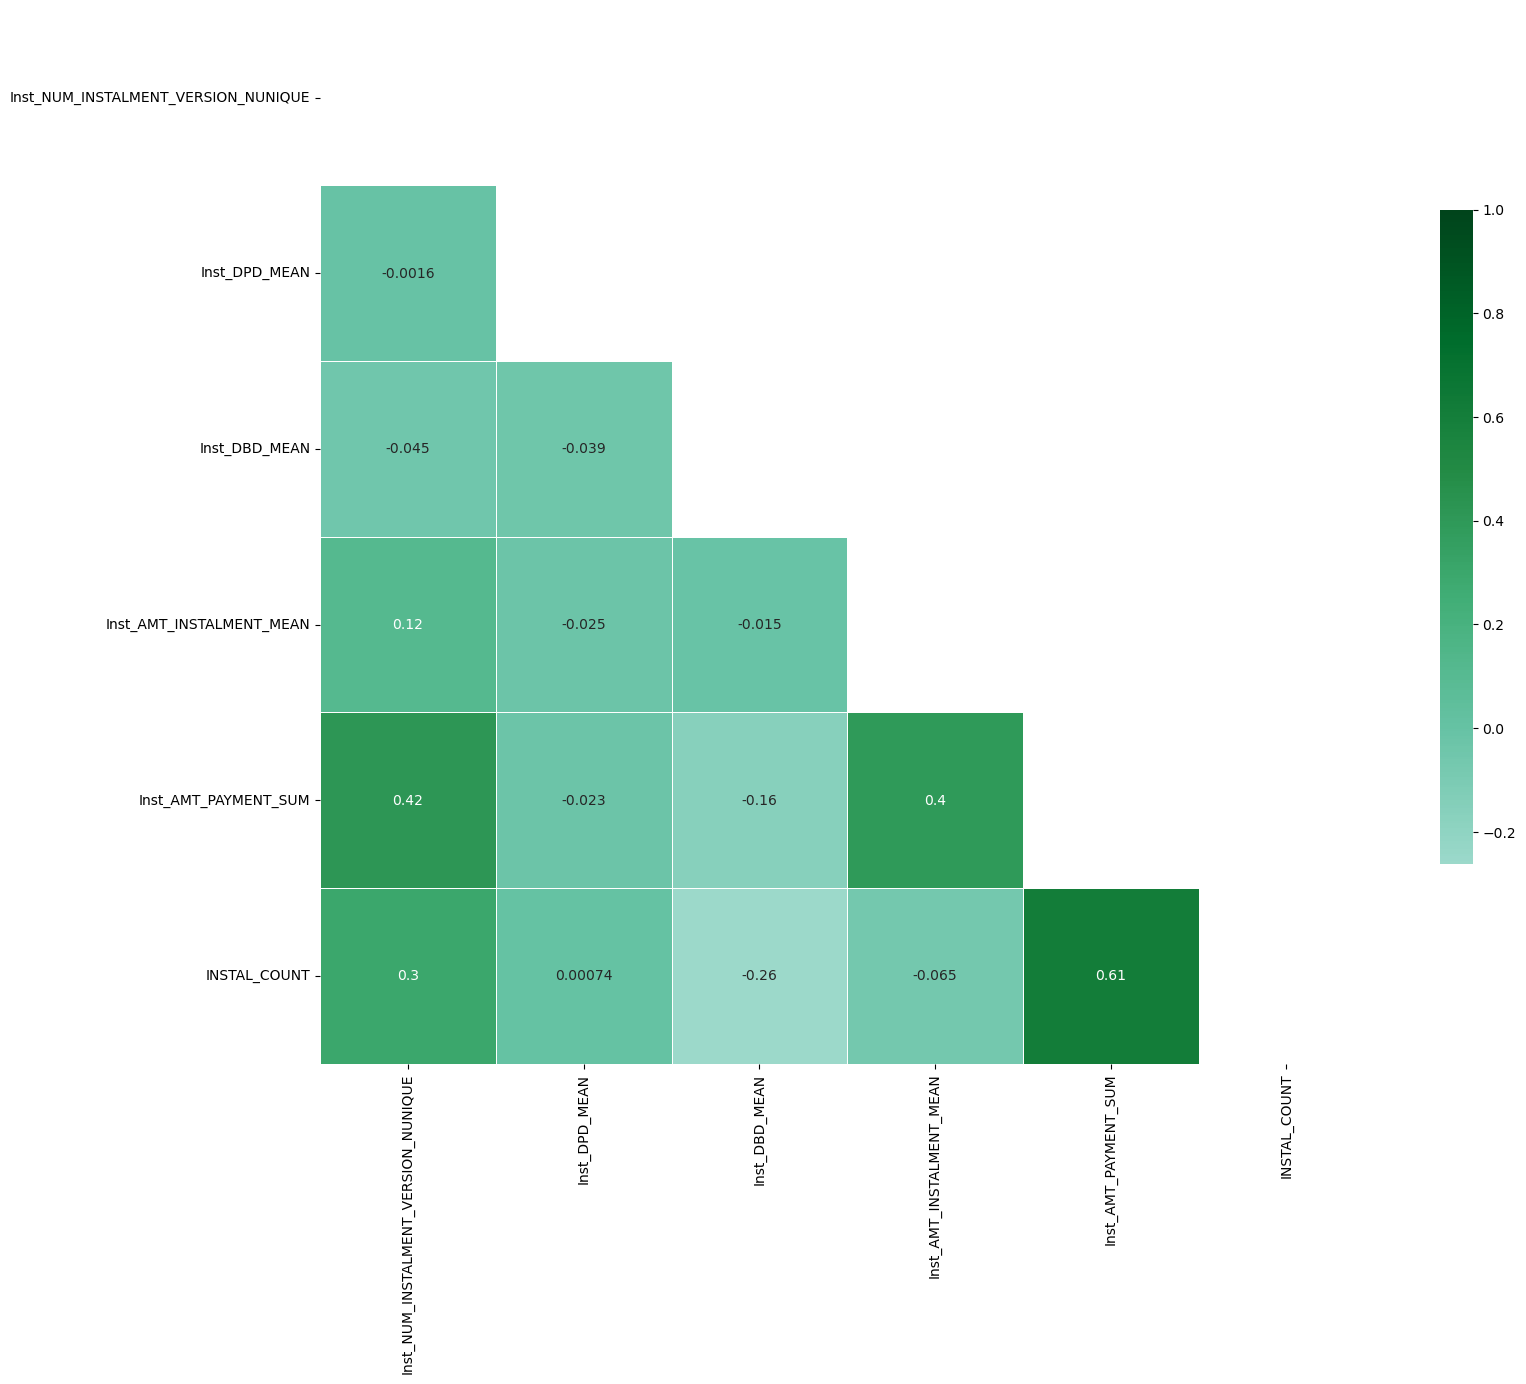

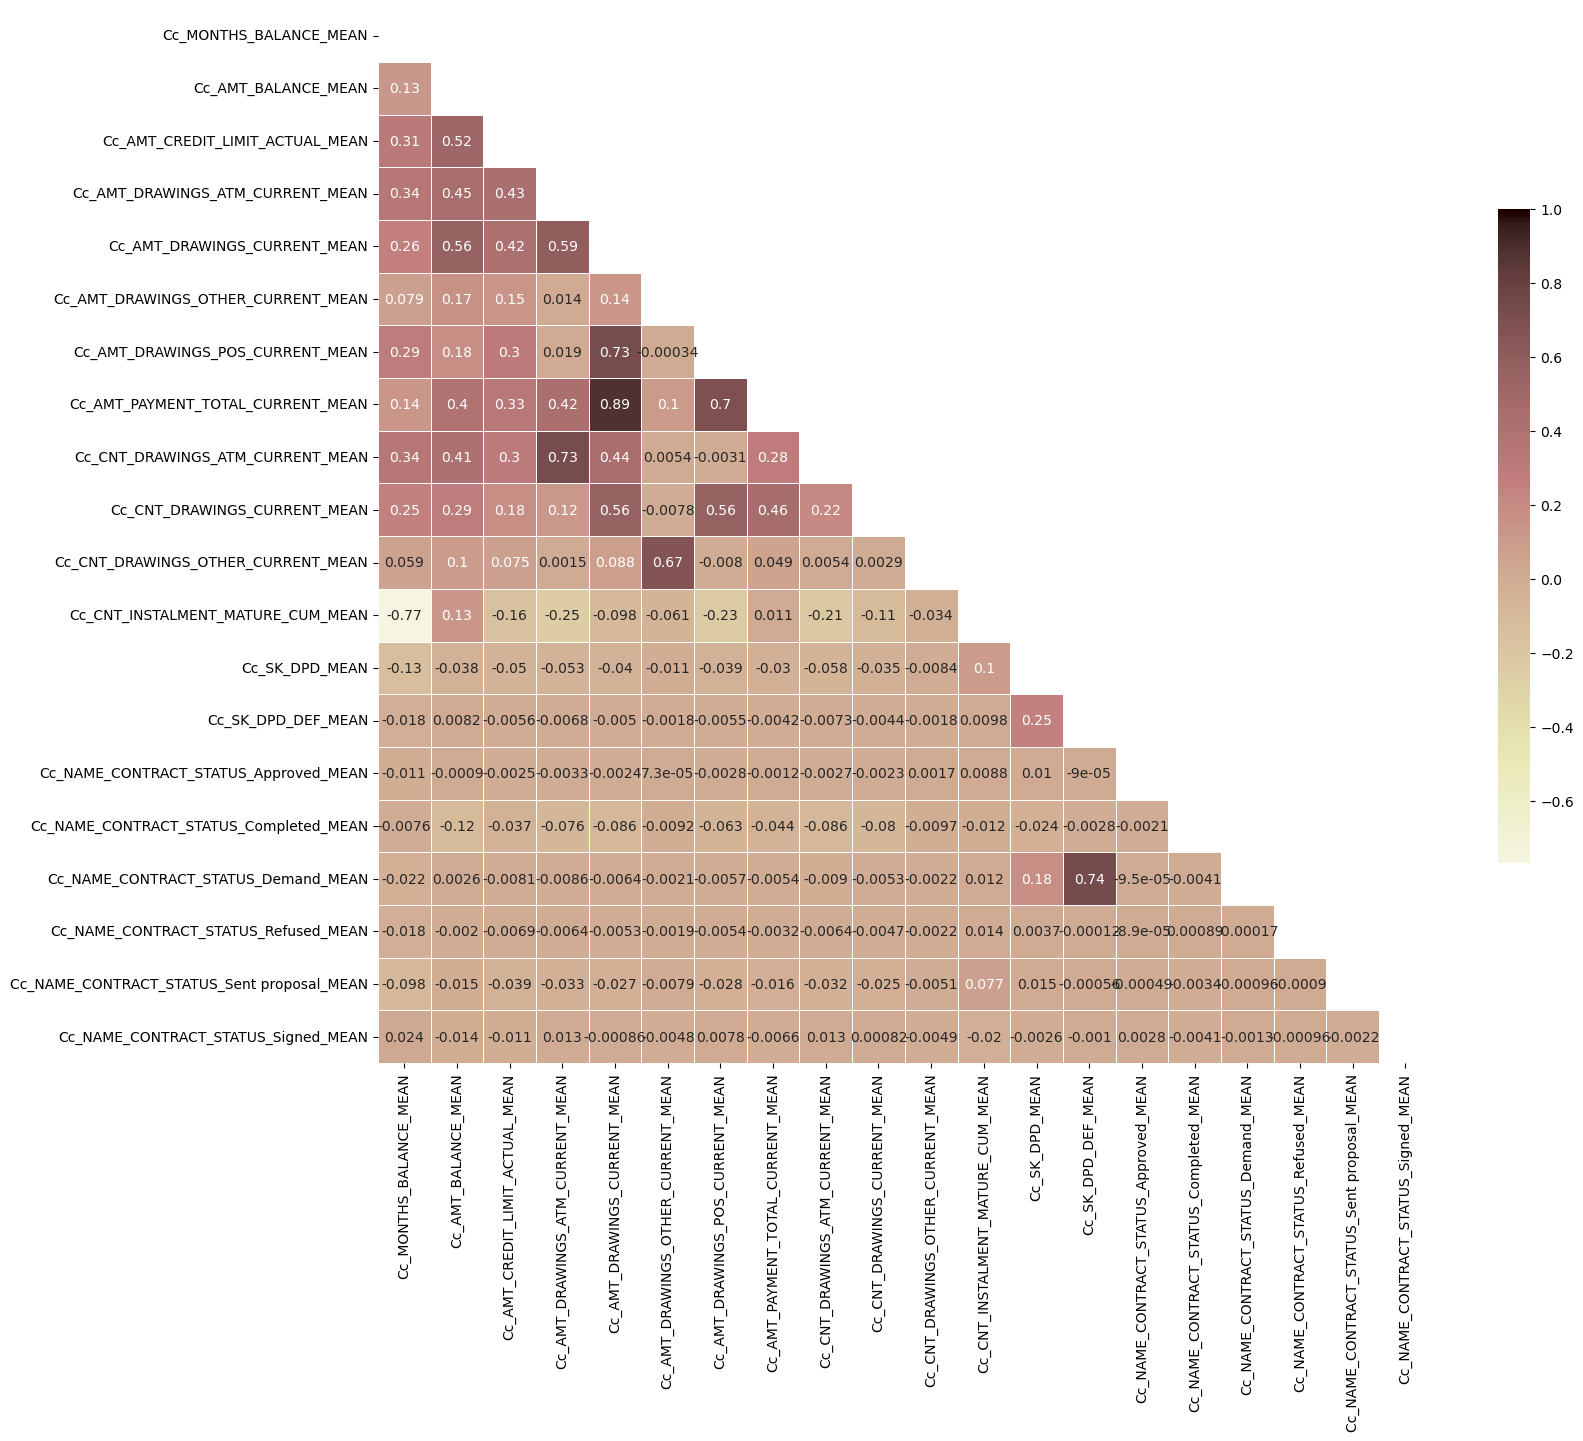

In [119]:
main()  

# Notebooks

* notebook data engineering

notebook models

notebook gridsearch hyperparametres

gridsearch personnalise hyperparametres
cutoff, autre que f1. Considerer la marge. faire bouger le seuil et analyser la matrice de confusion. Faux negatif plus grave.

shap

dash


# Bibliography


Tutorials

https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search/notebook


Encoding

https://medium.com/analytics-vidhya/different-type-of-feature-engineering-encoding-techniques-for-categorical-variable-encoding-214363a016fb

https://danilzherebtsov.medium.com/advanced-categoric-encoding-like-a-pro-onehot-meantarget-woe-frequency-factorization-99dc69477bf3

https://medium.com/analytics-vidhya/different-type-of-feature-engineering-encoding-techniques-for-categorical-variable-encoding-214363a016fb

https://github.com/scikit-learn-contrib/category_encoders/tree/master/category_encoders



7ème dans le concours Kaggle

Kernel avec un meilleur AUC et un feature engineering métier mais assez long a entrainer.
https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

In [ ]:
"""
KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's 
categorical features. Other tables are using one-hot encode with mean, 
sum and a few different functions to aggregate. The main ideia was to add 
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def main(debug= False):
    num_rows = 30000 if debug else None
    with timer("application_train and application_test"):
        df = get_train_test(DATA_DIRECTORY, num_rows= num_rows)
        print("Application dataframe shape: ", df.shape)
    with timer("Bureau and bureau_balance data"):
        bureau_df = get_bureau(DATA_DIRECTORY, num_rows= num_rows)
        df = pd.merge(df, bureau_df, on='SK_ID_CURR', how='left')
        print("Bureau dataframe shape: ", bureau_df.shape)
        del bureau_df; gc.collect()
    with timer("previous_application"):
        prev_df = get_previous_applications(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
        print("Previous dataframe shape: ", prev_df.shape)
        del prev_df; gc.collect()
    with timer("previous applications balances"):
        pos = get_pos_cash(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
        print("Pos-cash dataframe shape: ", pos.shape)
        del pos; gc.collect()
        ins = get_installment_payments(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
        print("Installments dataframe shape: ", ins.shape)
        del ins; gc.collect()
        cc = get_credit_card(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
        print("Credit card dataframe shape: ", cc.shape)
        del cc; gc.collect()
    # Add ratios and groupby between different tables
    df = add_ratios_features(df)
    df = reduce_memory(df)
    lgbm_categorical_feat = [
        'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']
    with timer("Run LightGBM"):
        feat_importance = kfold_lightgbm_sklearn(df, lgbm_categorical_feat)
        print(feat_importance)


def add_ratios_features(df):
    # CREDIT TO INCOME RATIO
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
    df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
    # PREVIOUS TO CURRENT ANNUITY RATIO
    df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
    df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
    # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
    df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    # DAYS DIFFERENCES AND RATIOS
    df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return df


# ------------------------- LIGHTGBM MODEL -------------------------

def kfold_lightgbm_sklearn(data, categorical_feature = None):
    df = data[data['TARGET'].notnull()]
    test = data[data['TARGET'].isnull()]
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))
    del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
    predictors = list(filter(lambda v: v not in del_features, df.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['TARGET'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['TARGET'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['TARGET'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(df['TARGET'], oof_preds))
    test['TARGET'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Generate oof csv
        oof = pd.DataFrame()
        oof['SK_ID_CURR'] = df['SK_ID_CURR'].copy()
        df['PREDICTIONS'] = oof_preds.copy()
        df['TARGET'] = df['TARGET'].copy()
        df.to_csv('oof{}.csv'.format(SUBMISSION_SUFIX), index=False)
        # Save submission (test data) and feature importance
        test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
    return mean_importance


# ------------------------- APPLICATION PIPELINE -------------------------

def get_train_test(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)
    df = train.append(test)
    del train, test; gc.collect()
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    df = drop_application_columns(df)
    return df


def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG',
         'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df


def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0


# ------------------------- BUREAU PIPELINE -------------------------

def get_bureau(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
    # Flag months with late payments (days past due)
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

    # Aggregate by number of months in balance and merge with bureau (loan length agg)
    features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
    agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
    agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
    bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
    del agg_length; gc.collect()

    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
    del active, closed; gc.collect()
    # Aggregations for the main loan types
    for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
        agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
    # Time based aggregations: last x months
    for time_frame in [6, 12]:
        prefix = "BUREAU_LAST{}M_".format(time_frame)
        time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
        agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
        del time_frame_df; gc.collect()

    # Last loan max overdue
    sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
    gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
    gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
    agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
    agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
    return agg_bureau


def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

# ------------------------- PREVIOUS PIPELINE -------------------------

def get_previous_applications(path, num_rows= None):
    """ Process previous_application.csv and return a pandas dataframe. """
    prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

    # One-hot encode most important categorical features
    ohe_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    # Active loans - approved and not complete yet (last_due 365243)
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
    # Find how much was already payed in active loans (using installments csv)
    active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
    active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
    active_pay_agg.reset_index(inplace= True)
    # Active loans: difference of what was payed and installments
    active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                             active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df; gc.collect()

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df; gc.collect()
    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused; gc.collect()
    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id; gc.collect()
    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = 'PREV_LAST{}M_'.format(time_frame)
        agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df; gc.collect()
    del prev; gc.collect()
    return agg_prev

# ------------------------- POS-CASH PIPELINE -------------------------

def get_pos_cash(path, num_rows= None):
    """ Process POS_CASH_balance.csv and return a pandas dataframe. """
    pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
    pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Aggregate by SK_ID_CURR
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
    # Sort and group by SK_ID_PREV
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df = pd.DataFrame()
    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()
    # Percentage of previous loans completed and completed before initial term
    df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()
    # Group by SK_ID_CURR and merge
    df_gp = df.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')
    del df, gp, df_gp, sort_pos; gc.collect()

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')
    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR','LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    # Drop some useless categorical features
    drop_features = [
        'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
        'POS_NAME_CONTRACT_STATUS_XNA_MEAN']
    pos_agg.drop(drop_features, axis=1, inplace=True)
    return pos_agg

# ------------------------- INSTALLMENTS PIPELINE -------------------------

def get_installment_payments(path, num_rows= None):
    """ Process installments_payments.csv and return a pandas dataframe. """
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
    # Group payments and get Payment difference
    pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
    pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
    pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
    pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
    # Payment Entry: Days past due and Days before due
    pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
    pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
    pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)
    # Flag late payment
    pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)
    # Percentage of payments that were late
    pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']
    pay['LATE_PAYMENT_RATIO'] = pay.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)
    # Flag late payments that have a significant amount
    pay['SIGNIFICANT_LATE_PAYMENT'] = pay['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    # Flag k threshold late payments
    pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    # Aggregations by SK_ID_CURR
    pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

    # Installments in the last x months
    for months in [36, 60]:
        recent_prev_id = pay[pay['DAYS_INSTALMENT'] >= -30*months]['SK_ID_PREV'].unique()
        pay_recent = pay[pay['SK_ID_PREV'].isin(recent_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        pay_agg = group_and_merge(pay_recent, pay_agg, prefix, INSTALLMENTS_TIME_AGG)

    # Last x periods trend features
    group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                      'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
    gp = pay[group_features].groupby('SK_ID_CURR')
    func = partial(trend_in_last_k_instalment_features, periods= INSTALLMENTS_LAST_K_TREND_PERIODS)
    g = parallel_apply(gp, func, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

    # Last loan features
    g = parallel_apply(gp, installments_last_loan_features, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')
    return pay_agg


def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]
        features = add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))
        features = add_trend_feature(features, gr_period, 'PAID_OVER_AMOUNT',
                                           '{}_TREND_'.format(period))
    return features


def installments_last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features

# ------------------------- CREDIT CARD PIPELINE -------------------------

def get_credit_card(path, num_rows= None):
    """ Process credit_card_balance.csv and return a pandas dataframe. """
    cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
    cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)
    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Aggregations by SK_ID_CURR
    cc_agg = cc.groupby('SK_ID_CURR').agg(CREDIT_CARD_AGG)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg.reset_index(inplace= True)

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    # Aggregations for last x months
    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)
    return cc_agg


# ------------------------- UTILITY FUNCTIONS -------------------------

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)


def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns


def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns


def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg

        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                     columns={feature_name: '{}_{}'.format(feature_name,agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features


def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0: num_workers = NUM_THREADS
    #n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features


def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_


def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

# ------------------------- CONFIGURATIONS -------------------------

# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = ".."
SUBMISSION_SUFIX = "_model2_04"

# INSTALLMENTS TREND PERIODS
INSTALLMENTS_LAST_K_TREND_PERIODS =  [12, 24, 60, 120]

# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_FOLDS = 10
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

# AGGREGATIONS
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

INSTALLMENTS_AGG = {
    'SK_ID_PREV': ['size', 'nunique'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean', 'sum'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
    'PAID_OVER': ['mean']
}

INSTALLMENTS_TIME_AGG = {
    'SK_ID_PREV': ['size'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
}

CREDIT_CARD_AGG = {
    'MONTHS_BALANCE': ['min'],
    'AMT_BALANCE': ['max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['max', 'sum'],
    'LIMIT_USE': ['max', 'mean'],
    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],
}

CREDIT_CARD_TIME_AGG = {
    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
    'SK_DPD': ['max', 'sum'],
    'AMT_BALANCE': ['mean', 'max'],
    'LIMIT_USE': ['max', 'mean']
}


if __name__ == "__main__":
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 100)
    with timer("Pipeline total time"):
        main(debug= False)

Application dataframe shape:  (356250, 83)
application_train and application_test - done in 53s
Bureau dataframe shape:  (305811, 156)
Bureau and bureau_balance data - done in 49s


/var/folders/b9/mh9mrnx12vj9cxhvcyrtfy5r0000gn/T/ipykernel_18583/38265129.py:398: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']


Previous dataframe shape:  (338857, 225)
previous_application - done in 62s
Pos-cash dataframe shape:  (337252, 24)


Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'trend_in_last_k_instalment_features' on <module '__main__' (built-in)>
Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self

Process SpawnPoolWorker-13:
Traceback (most recent call last):
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'trend_in_last_k_instalment_features' on <module '__main__' (built-in)>
Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/mcBedini/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **se